<a href="https://colab.research.google.com/github/El20082/LLM-Synthetic-Geometric-Dataset/blob/main/Data_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [ ]:
import matplotlib.pyplot as plt
from functools import cmp_to_key
import random
import io
from PIL import Image
import os
import re
import json
import math

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Convex Hull Algorithm

Convex Hull using Graham Scan:
https://www.geeksforgeeks.org/convex-hull-using-graham-scan/



In [ ]:
# A Python3 program to find convex hull of a set of points. Refer
# https://www.geeksforgeeks.org/orientation-3-ordered-points/
# for explanation of orientation()

# A class used to store the x and y coordinates of points
class Point:
    def __init__(self, x = None, y = None):
        self.x = x
        self.y = y

# A global point needed for sorting points with reference
# to the first point
p0 = Point(0, 0)

# A utility function to find next to top in a stack
def nextToTop(S):
    return S[-2]

# A utility function to return square of distance
# between p1 and p2
def distSq(p1, p2):
    return ((p1.x - p2.x) * (p1.x - p2.x) +
            (p1.y - p2.y) * (p1.y - p2.y))

# To find orientation of ordered triplet (p, q, r).
# The function returns following values
# 0 --> p, q and r are collinear
# 1 --> Clockwise
# 2 --> Counterclockwise
def orientation(p, q, r):
    val = ((q.y - p.y) * (r.x - q.x) -
           (q.x - p.x) * (r.y - q.y))
    if val == 0:
        return 0  # collinear
    elif val > 0:
        return 1  # clock wise
    else:
        return 2  # counterclock wise

# A function used by cmp_to_key function to sort an array of
# points with respect to the first point
def compare(p1, p2):

    # Find orientation
    o = orientation(p0, p1, p2)
    if o == 0:
        if distSq(p0, p2) >= distSq(p0, p1):
            return -1
        else:
            return 1
    else:
        if o == 2:
            return -1
        else:
            return 1

# Prints convex hull of a set of n points.
def convexHull(points, n):

    # Find the bottommost point
    ymin = points[0].y
    min = 0
    for i in range(1, n):
        y = points[i].y

        # Pick the bottom-most or choose the left
        # most point in case of tie
        if ((y < ymin) or
            (ymin == y and points[i].x < points[min].x)):
            ymin = points[i].y
            min = i

    # Place the bottom-most point at first position
    points[0], points[min] = points[min], points[0]

    # Sort n-1 points with respect to the first point.
    # A point p1 comes before p2 in sorted output if p2
    # has larger polar angle (in counterclockwise
    # direction) than p1
    p0 = points[0]
    points = sorted(points, key=cmp_to_key(compare))

    # If two or more points make same angle with p0,
    # Remove all but the one that is farthest from p0
    # Remember that, in above sorting, our criteria was
    # to keep the farthest point at the end when more than
    # one points have same angle.
    m = 1  # Initialize size of modified array
    for i in range(1, n):

        # Keep removing i while angle of i and i+1 is same
        # with respect to p0
        while ((i < n - 1) and
        (orientation(p0, points[i], points[i + 1]) == 0)):
            i += 1

        points[m] = points[i]
        m += 1  # Update size of modified array

    # If modified array of points has less than 3 points,
    # convex hull is not possible
    if m < 3:
        return

    # Create an empty stack and push first three points
    # to it.
    S = []
    S.append(points[0])
    S.append(points[1])
    S.append(points[2])

    # Process remaining n-3 points
    for i in range(3, m):

        # Keep removing top while the angle formed by
        # points next-to-top, top, and points[i] makes
        # a non-left turn
        while ((len(S) > 1) and
        (orientation(nextToTop(S), S[-1], points[i]) != 2)):
            S.pop()
        S.append(points[i])

    # Now stack has the output points,
    # print contents of stack
    results = []
    while S:
        p = S[-1]
        results.append((p.x, p.y))
        S.pop()

    return results

# Function to generate geometric shape

In [ ]:
def generate_geometric_shape(input_points, max_num_edge_with_points, max_num_points_on_each_edge, max_num_edge_each_edge_point):
    # Get the vertices for the geometric shape
    points = []
    for point in input_points:
        points.append(Point(point[0], point[1]))
    n = len(points)
    vertices = convexHull(points, n)

    # Get the boundary edges for the geometric shape
    bound_edges = []
    for i in range(len(vertices)):
        bound_edges.append((vertices[i - 1], vertices[i]))
    points_on_edge = []
    points_on_edge_parent = {}
    edge_with_points = {}
    all_points = vertices.copy()

    # Get the points on the edges and record their parent edge
    num_edge_with_points = min(max_num_edge_with_points, len(vertices))
    edge_with_points_on_edge = random.sample(bound_edges, num_edge_with_points)
    for edge in edge_with_points_on_edge:
        num_points_on_edge = random.randint(1,max_num_points_on_each_edge)
        edge_point_ratios = [i/(num_points_on_edge+1) for i in range(1,num_points_on_edge+1)]
        x1, y1 =edge[0]
        x2, y2 = edge[1]
        dx = x2 - x1
        dy = y2 - y1
        for edge_point_ratio in edge_point_ratios:
            point_on_edge=(x1+dx*edge_point_ratio,y1+dy*edge_point_ratio)
            points_on_edge_parent[point_on_edge] = edge
            points_on_edge.append(point_on_edge)
            all_points.append(point_on_edge)
            if edge not in edge_with_points:
                edge_with_points[edge] = [point_on_edge]
            else:
                edge_with_points[edge].append(point_on_edge)

    # Connect the points on edges with other points
    inner_edges = []
    for point_on_edge in points_on_edge_parent:
        num_edge_each_edge_point = random.randint(1,max_num_edge_each_edge_point)
        parent_edge = points_on_edge_parent[point_on_edge]
        possible_linking_point = []
        for point in all_points:
            if point in parent_edge or point in edge_with_points[parent_edge] or [point, point_on_edge] in inner_edges:
                continue
            possible_linking_point.append(point)
        num_edge_each_edge_point = min(num_edge_each_edge_point, len(possible_linking_point))
        linking_points = random.sample(possible_linking_point, num_edge_each_edge_point)
        for linking_point in linking_points:
            inner_edges.append([point_on_edge, linking_point])

    # Get geometric shape information
    image_info = {
        'vertices': vertices,
        'bound_edges': bound_edges,
        'points_on_edge': points_on_edge,
        'inner_edges': inner_edges,
        'edge_with_points': edge_with_points
    }

    return image_info

# Function to check the property of the generated shape

In [ ]:
def check_if_side_too_short(image_info):
  side_lengths = []
  for side in image_info['bound_edges']:
    x1, y1 = side[0]
    x2, y2 = side[1]
    len_side = math.sqrt((x1-x2)**2 + (y1-y2)**2)
    side_lengths.append(len_side)
  if max(side_lengths)/max(0.00000001,min(side_lengths))>5:
    return True
  if min(side_lengths)<3:
    return True
  return False

In [ ]:
def dot(vA, vB):
    return vA[0]*vB[0]+vA[1]*vB[1]

def ang(lineA, lineB):
    # Get nicer vector form
    vA = [(lineA[0][0]-lineA[1][0]), (lineA[0][1]-lineA[1][1])]
    vB = [(lineB[0][0]-lineB[1][0]), (lineB[0][1]-lineB[1][1])]
    # Get dot prod
    dot_prod = dot(vA, vB)
    # Get magnitudes
    magA = dot(vA, vA)**0.5
    magB = dot(vB, vB)**0.5
    # Get cosine value
    cos_ = dot_prod/magA/magB
    # Get angle in radians and then convert to degrees
    angle = math.acos(dot_prod/magB/magA)
    # Basically doing angle <- angle mod 360
    ang_deg = math.degrees(angle)%360

    if ang_deg-180>=0:
        # As in if statement
        return 360 - ang_deg
    else:

        return ang_deg

In [ ]:
def check_if_ang_too_large(image_info):
  sides = image_info['bound_edges']
  for i in range(len(sides)):
    lineA = sides[i]
    if i == len(sides)-1:
      lineB = sides[0]
    else:
      lineB = sides[i+1]
    if ang(lineA, lineB)>150 or ang(lineA, lineB)<30:
      return True
  return False

# Function to generate image and metadata

In [ ]:
def make_image(image_info):
    vertices = image_info['vertices']
    bound_edges = image_info['bound_edges']
    points_on_edge = image_info['points_on_edge']
    inner_edges = image_info['inner_edges']

    fig, ax = plt.subplots()
    ax.set_aspect('equal', adjustable='box')

    for edge in bound_edges:
        ax.plot([edge[0][0], edge[1][0]], [edge[0][1], edge[1][1]], 'k-')

    for edge in inner_edges:
        ax.plot([edge[0][0], edge[1][0]], [edge[0][1], edge[1][1]], 'k-')

    ax.set_aspect('equal')

    # Save the plot
    plt.grid(False)
    plt.axis('off')
    plt.plot(legend=False)
    buf = io.BytesIO()
    plt.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    width, height = img.size
    img = img.resize((int(width * 256/height), 256))
    img = img.convert('RGB')
    return img

In [ ]:
def make_metadata(image_info):
  metadata = {
      'shape':'',
      'num_sides':-1,
      'num_lines':-1,
      'num_points':-1,
      'num_sides_with_points':-1,
      'num_points_on_sides':-1
  }
  num_vertices = len(image_info['vertices'])
  metadata['num_sides'] = num_vertices
  if num_vertices == 3:
    metadata['shape'] = 'triangle'
  elif num_vertices == 4:
    metadata['shape'] = 'quadrilateral'
  elif num_vertices == 5:
    metadata['shape'] = 'pentagon'
  elif num_vertices == 6:
    metadata['shape'] = 'hexagon'
  else:
    metadata['shape'] = 'other'
  metadata['num_lines'] = len(image_info['bound_edges']) + len(image_info['inner_edges'])
  metadata['num_points'] = len(image_info['vertices']) + len(image_info['points_on_edge'])
  metadata['num_sides_with_points'] = len(image_info['edge_with_points'])
  metadata['num_points_on_sides'] = [len(i) for i in image_info['edge_with_points'].values()]
  metadata.update(image_info)
  del metadata['edge_with_points']
  return metadata

# Function to generate data and save it to Google Drive

In [ ]:
def generate_data():
  input_points = []
  for _ in range(20):
    input_points.append([random.randint(0, 20), random.randint(0, 20)])
  max_num_edge_with_points = random.randint(0, 5)
  max_num_points_on_each_edge = random.randint(1, 2)
  max_num_edge_each_edge_point = random.randint(1, 5)

  image_info = generate_geometric_shape(input_points, max_num_edge_with_points, max_num_points_on_each_edge, max_num_edge_each_edge_point)
  print("Successfully generated shape!")

  if check_if_side_too_short(image_info):
    return False
  if check_if_ang_too_large(image_info):
    return False
  print("Successfully checked shape!")

  image = make_image(image_info)
  print("Successfully made image!")

  meta_data = make_metadata(image_info)
  print("Successfully made metadata!")

  dataset_dir = '/content/drive/MyDrive/llm_geometric_project/Datasets/dataset10/'
  directory_files = os.listdir(dataset_dir)
  image_files = []
  for file in directory_files:
    if file.endswith(".jpeg"):
      image_files.append(file)
  if not image_files:
    file_index = 0
  else:
    file_index = max([int(file[:-5]) for file in image_files])+1
  image_file_name = "{:05d}.jpeg".format(file_index)
  json_file_name = "{:05d}.json".format(file_index)
  print(image_file_name, json_file_name)

  image.save(os.path.join(dataset_dir, image_file_name))
  print("Successfully saved image!")
  with open(os.path.join(dataset_dir, json_file_name), 'w') as f:
      json.dump(meta_data, f)
  print("Successfully saved json!")
  return True

# Iteratively generate data and save to Google Drive

Successfully generated shape!
Successfully generated shape!
Successfully generated shape!
Successfully generated shape!
Successfully generated shape!
Successfully generated shape!
Successfully generated shape!
Successfully generated shape!
Successfully generated shape!
Successfully checked shape!
Successfully made image!
Successfully made metadata!
00000.jpeg 00000.json
Successfully saved image!
Successfully saved json!
Successfully generated shape!
Successfully generated shape!
Successfully generated shape!
Successfully generated shape!
Successfully generated shape!
Successfully generated shape!
Successfully generated shape!
Successfully generated shape!
Successfully checked shape!
Successfully made image!
Successfully made metadata!
00001.jpeg 00001.json
Successfully saved image!
Successfully saved json!
Successfully generated shape!
Successfully generated shape!
Successfully generated shape!
Successfully generated shape!
Successfully generated shape!
Successfully generated shape!
Su

<ipython-input-8-3b1a80f4fe8c>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


Successfully saved json!
Successfully generated shape!
Successfully generated shape!
Successfully generated shape!
Successfully generated shape!
Successfully generated shape!
Successfully generated shape!
Successfully generated shape!
Successfully generated shape!
Successfully generated shape!
Successfully generated shape!
Successfully generated shape!
Successfully generated shape!
Successfully checked shape!
Successfully made image!
Successfully made metadata!
00021.jpeg 00021.json
Successfully saved image!
Successfully saved json!
Successfully generated shape!
Successfully generated shape!
Successfully generated shape!
Successfully generated shape!
Successfully generated shape!
Successfully generated shape!
Successfully generated shape!
Successfully generated shape!
Successfully generated shape!
Successfully generated shape!
Successfully generated shape!
Successfully generated shape!
Successfully checked shape!
Successfully made image!
Successfully made metadata!
00022.jpeg 00022.jso

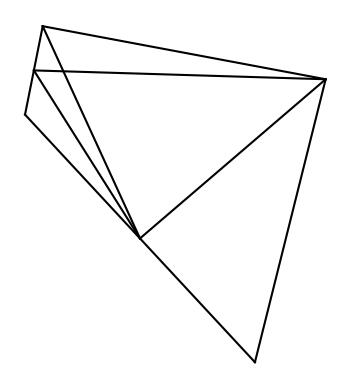

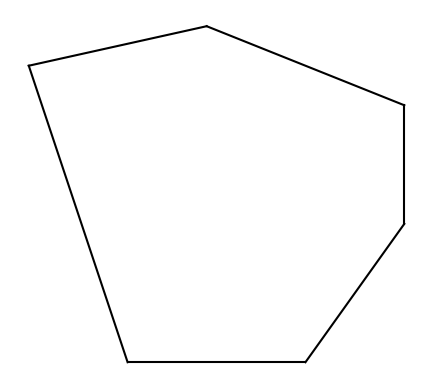

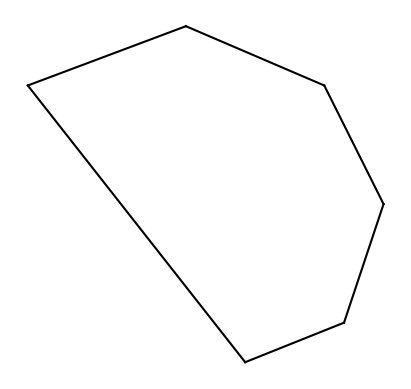

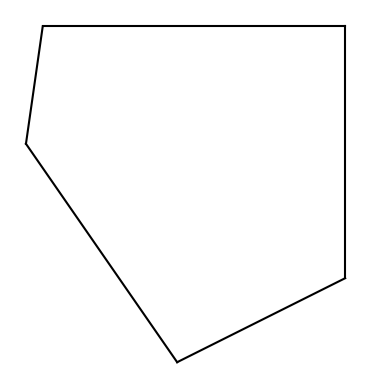

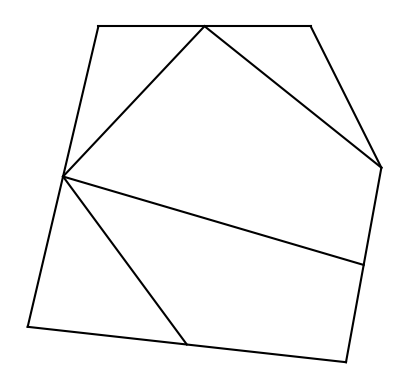

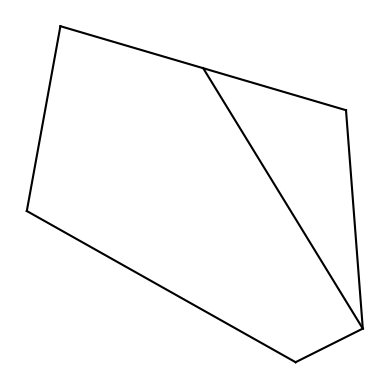

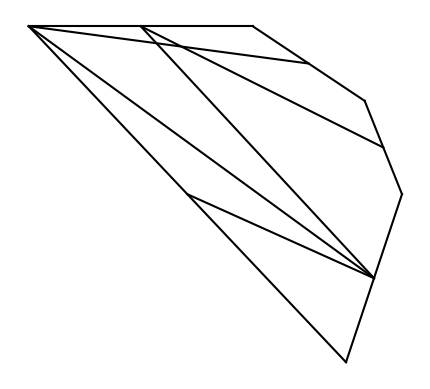

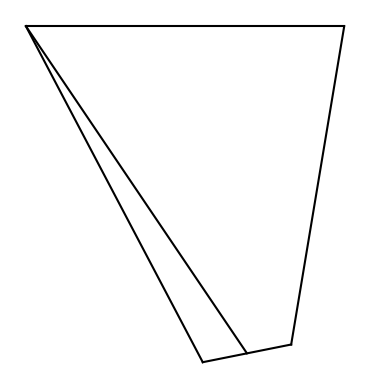

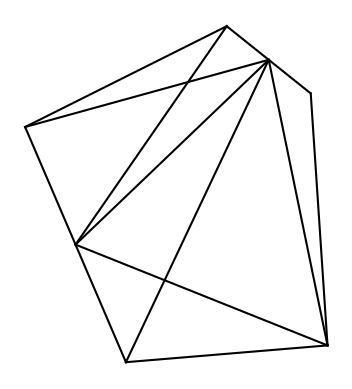

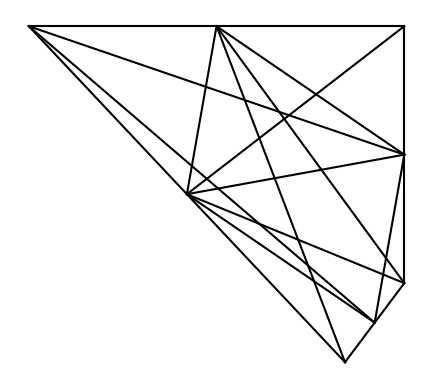

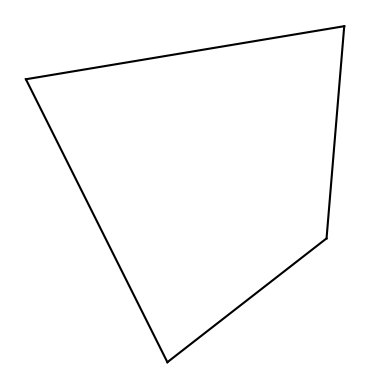

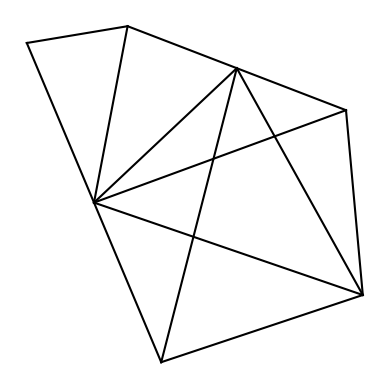

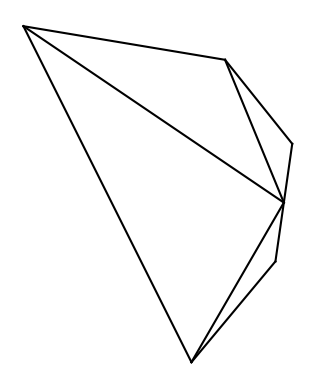

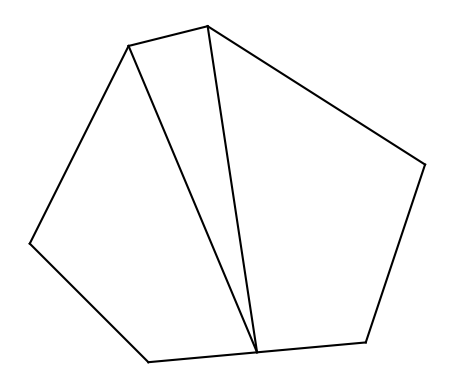

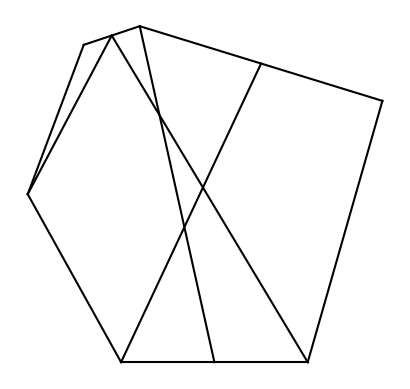

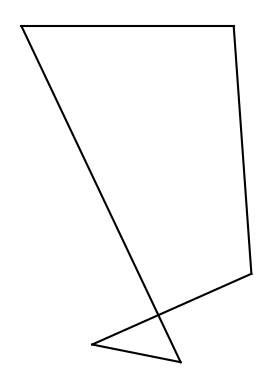

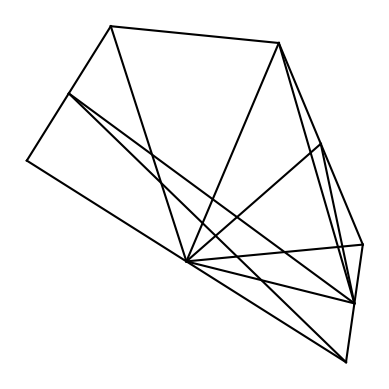

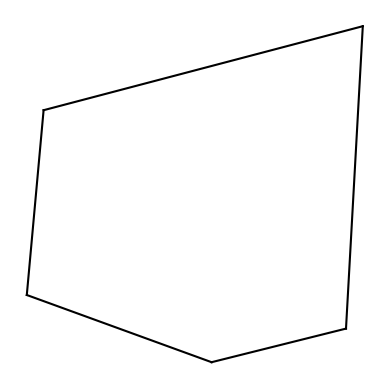

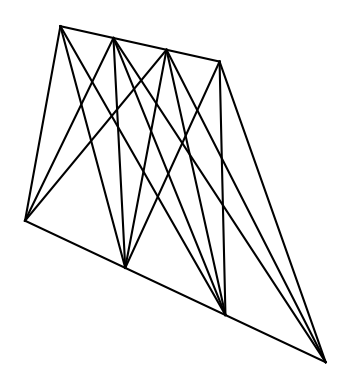

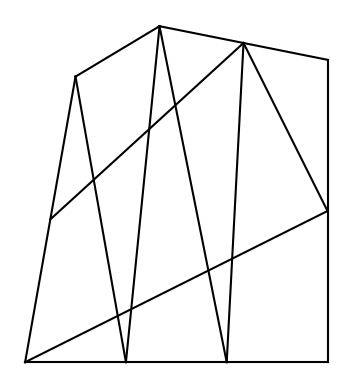

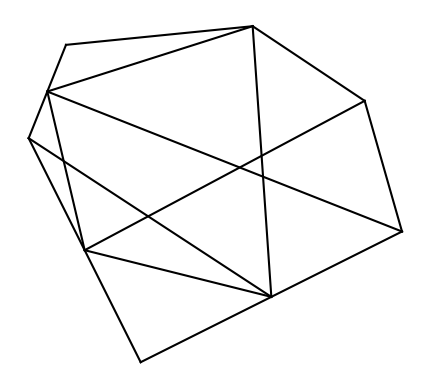

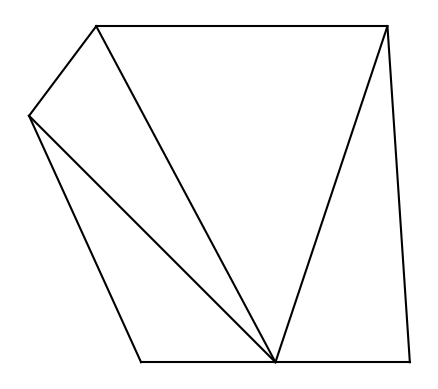

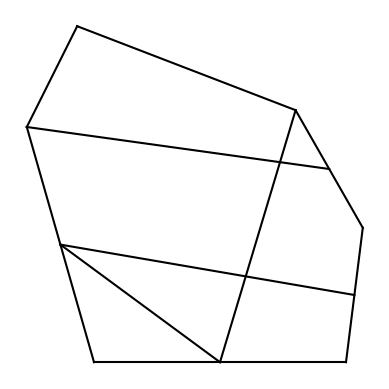

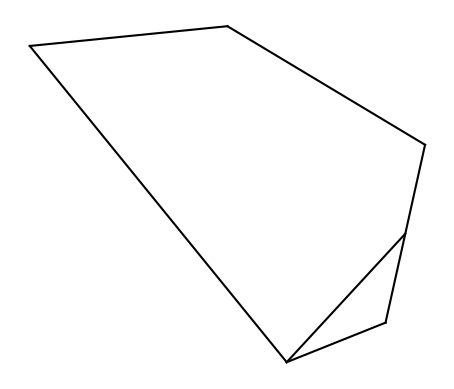

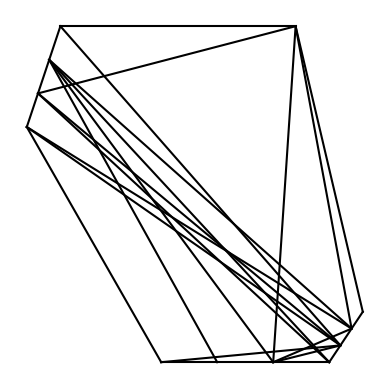

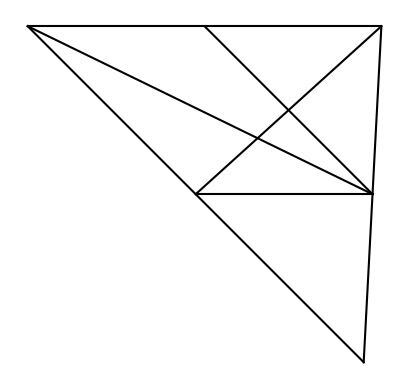

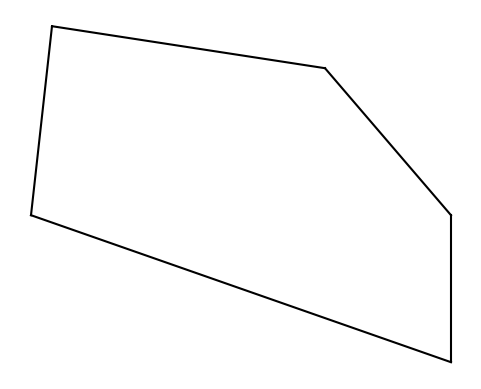

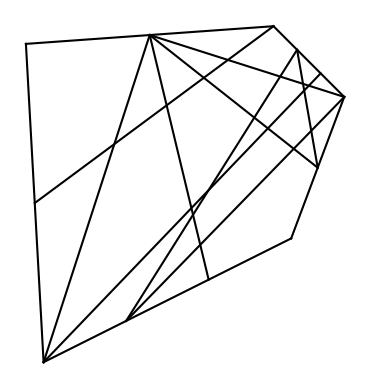

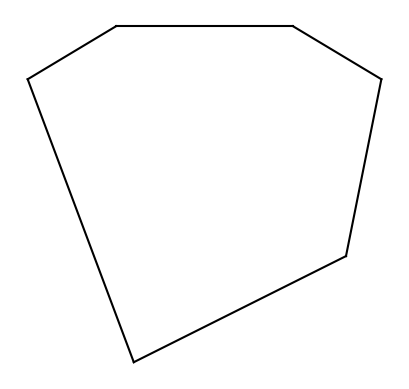

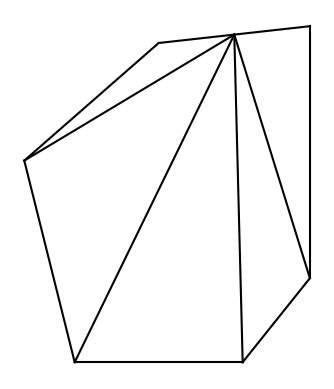

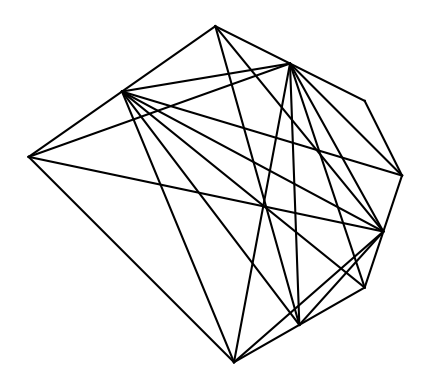

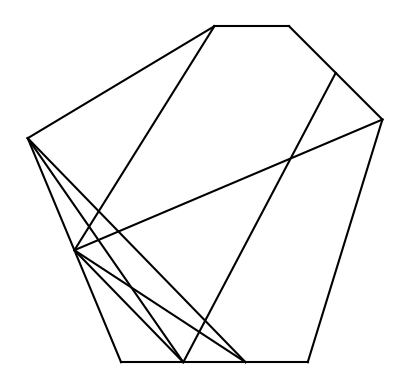

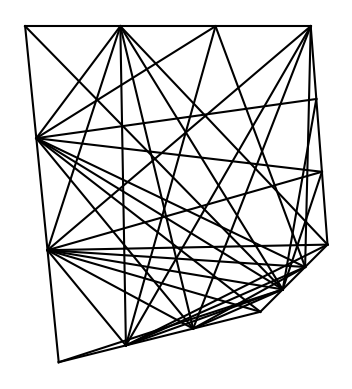

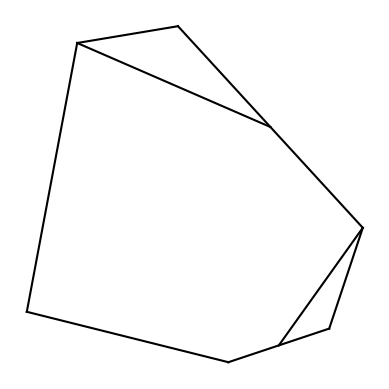

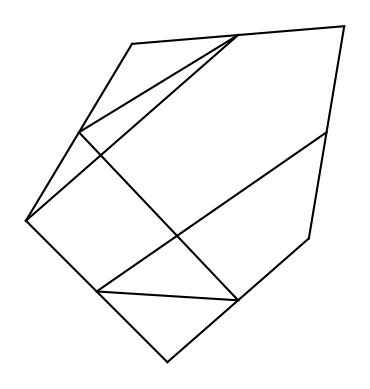

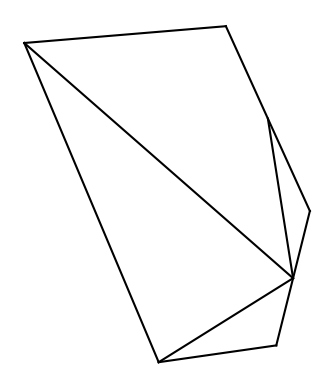

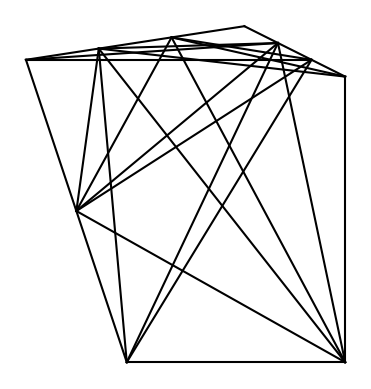

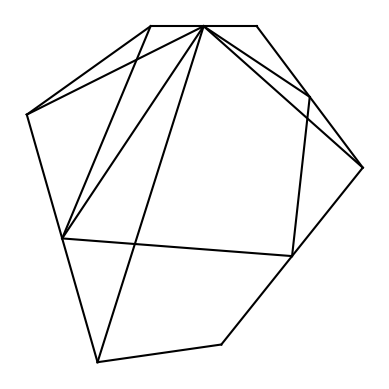

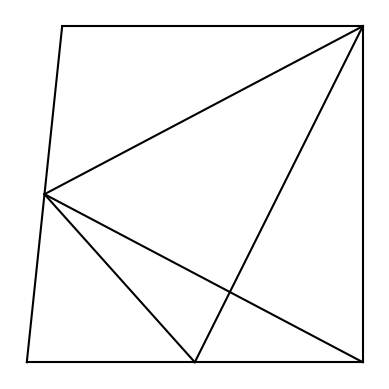

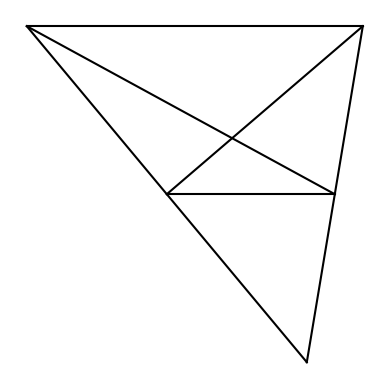

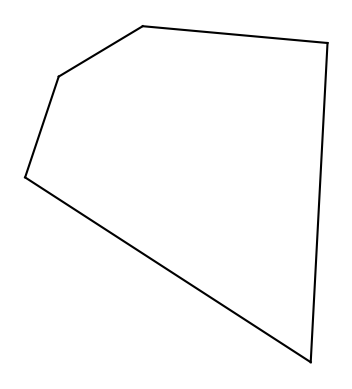

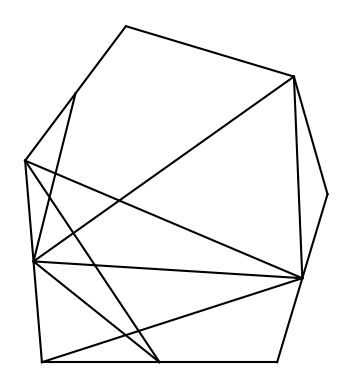

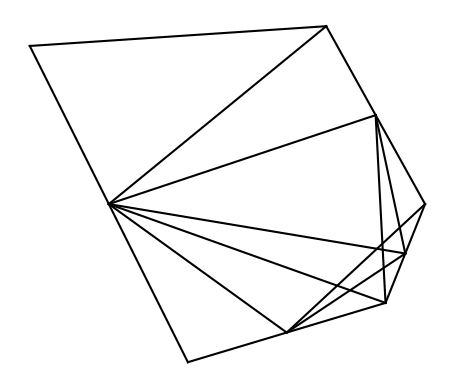

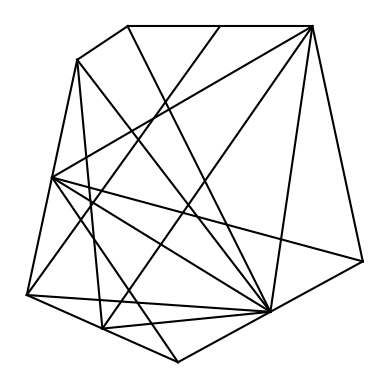

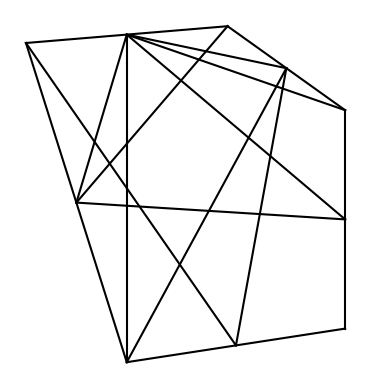

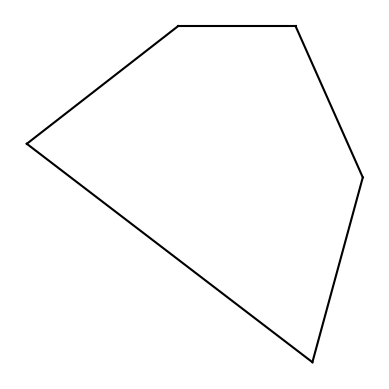

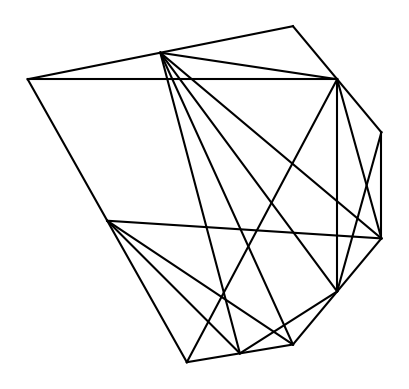

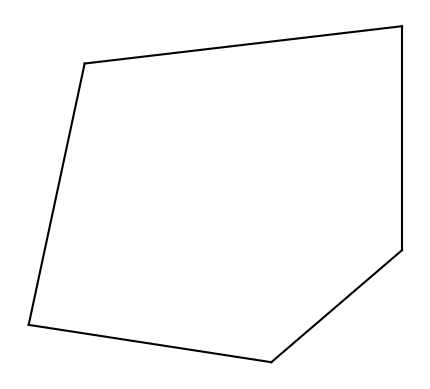

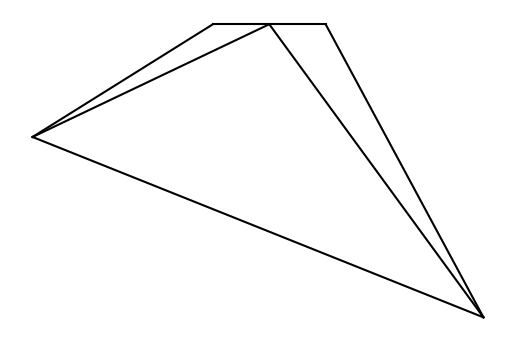

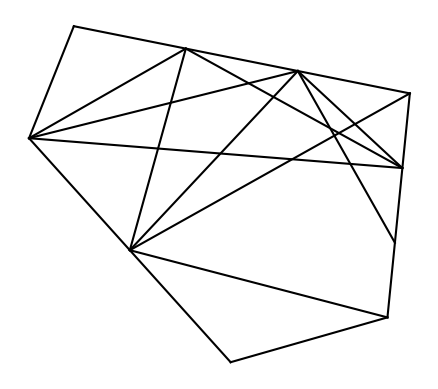

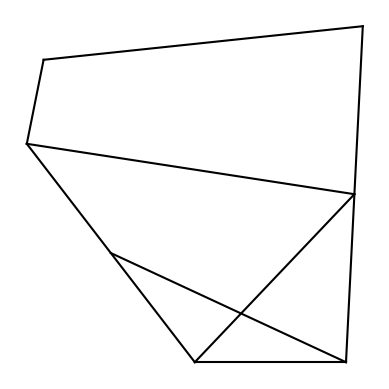

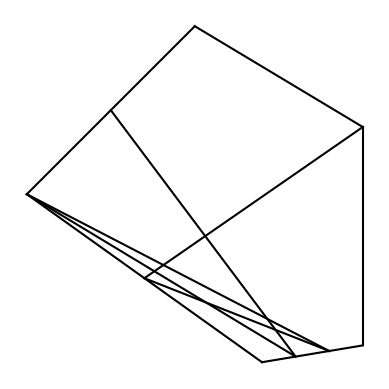

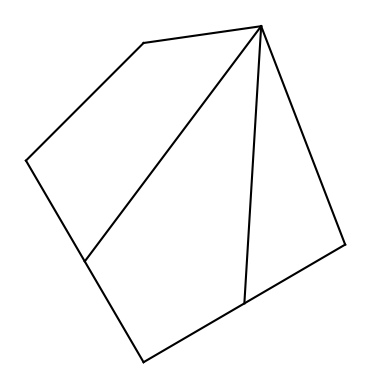

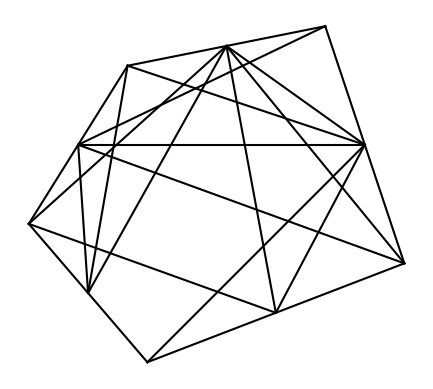

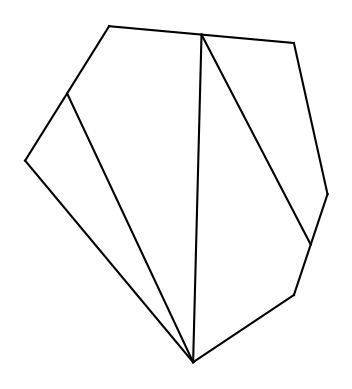

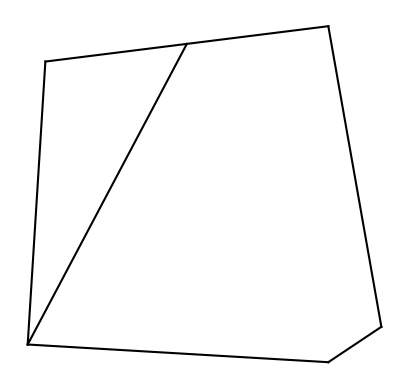

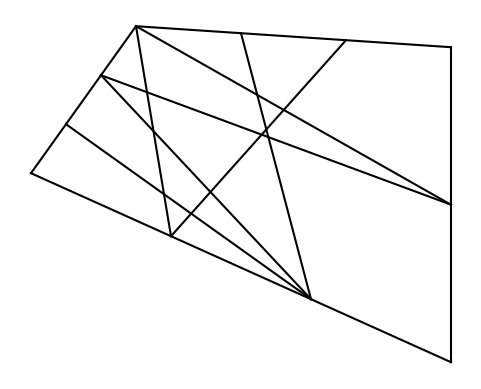

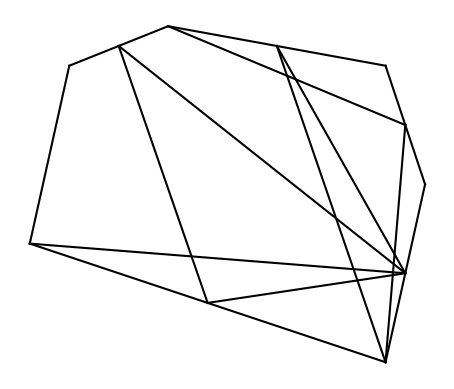

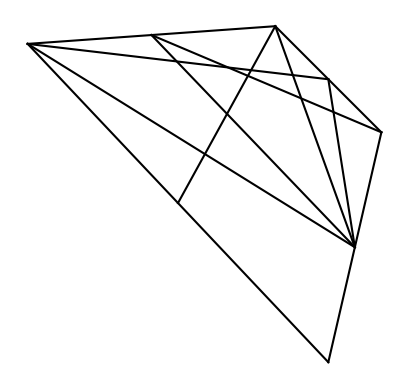

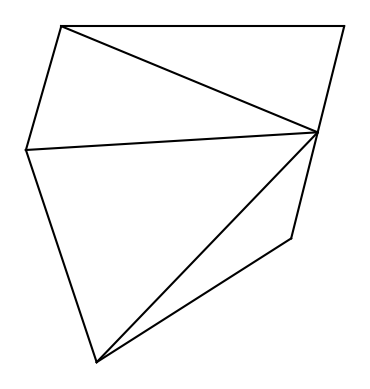

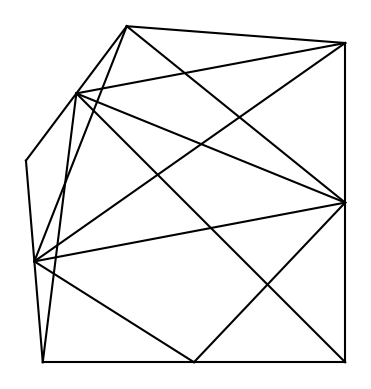

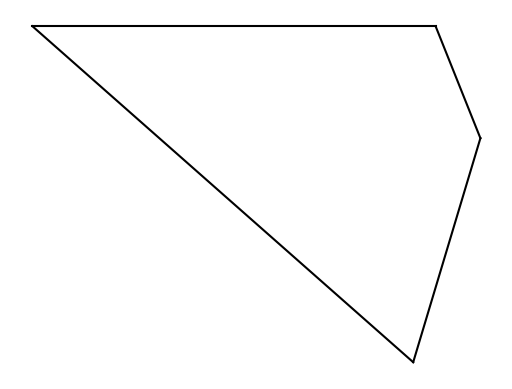

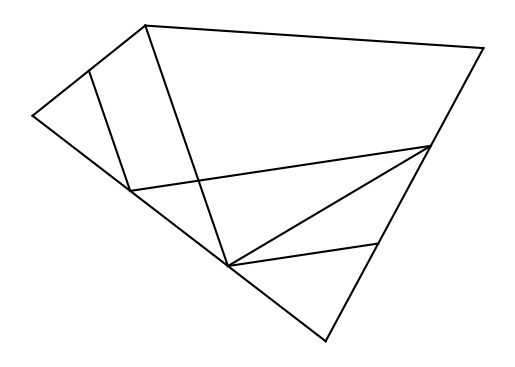

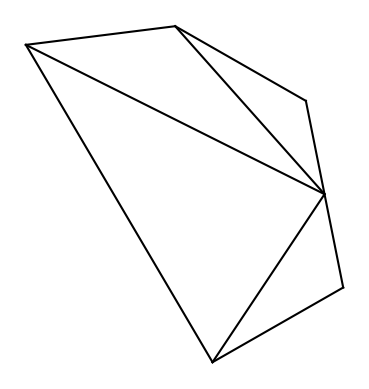

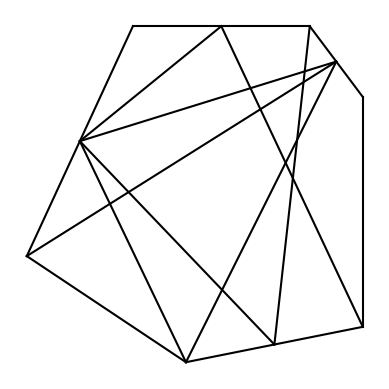

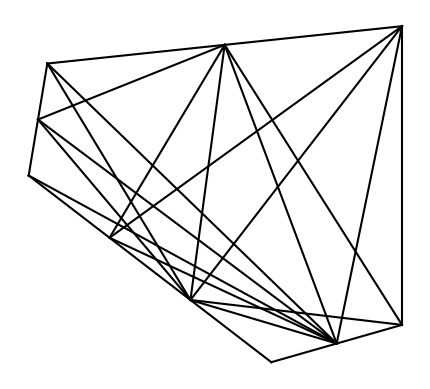

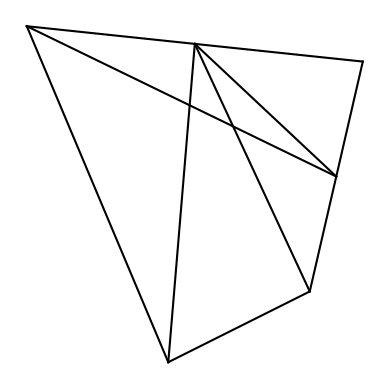

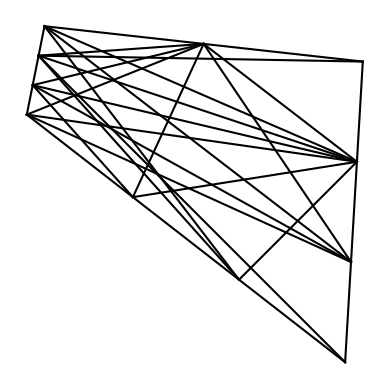

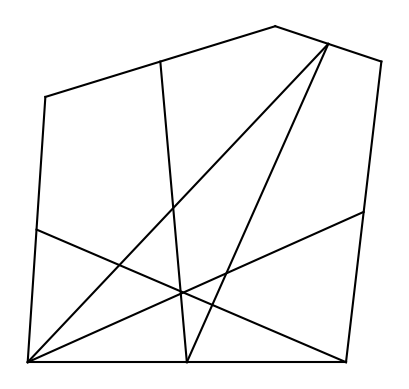

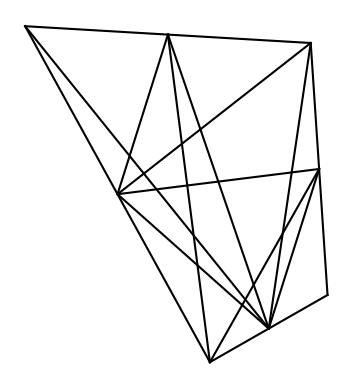

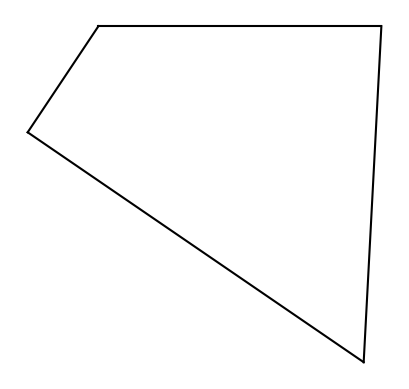

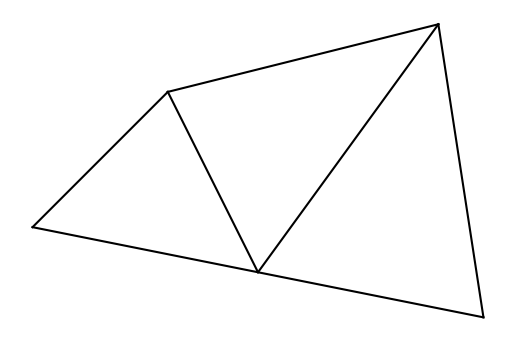

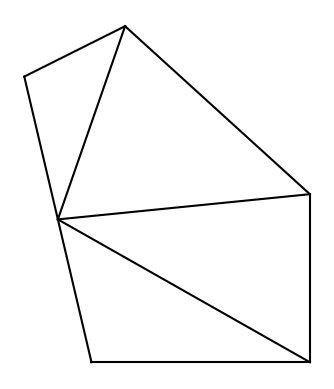

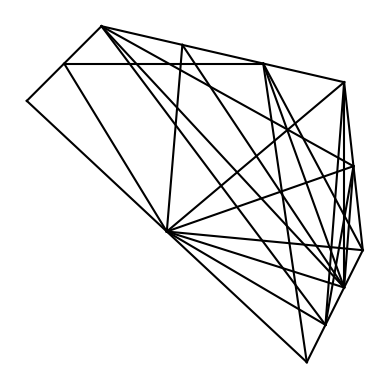

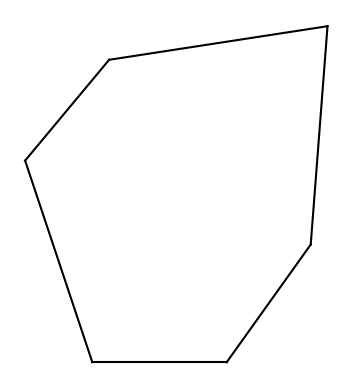

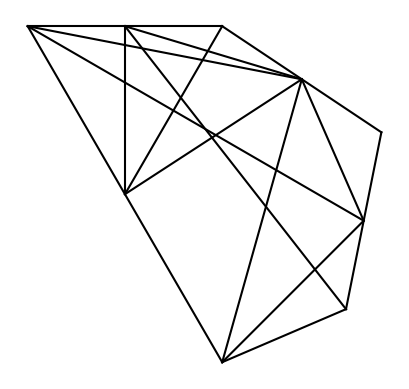

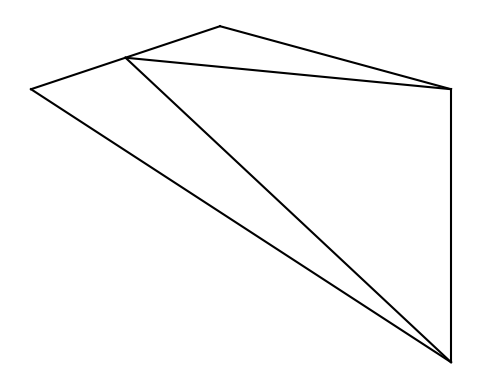

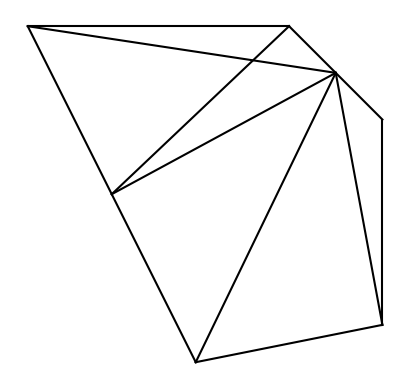

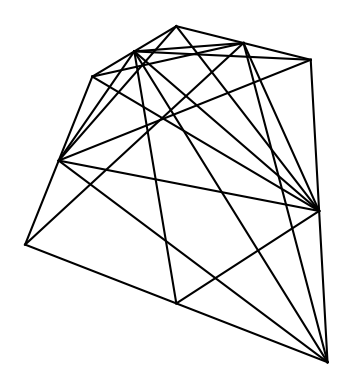

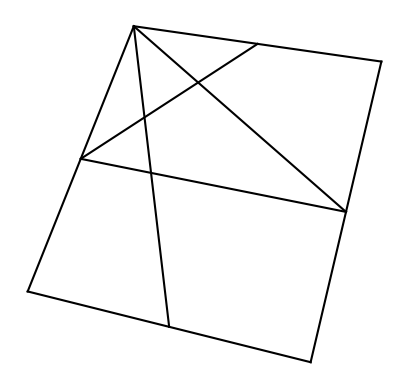

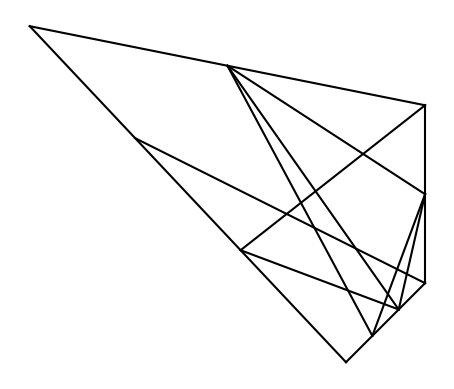

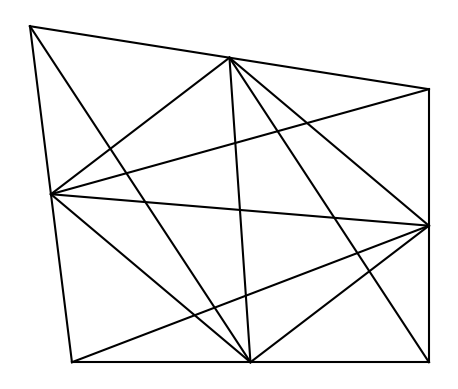

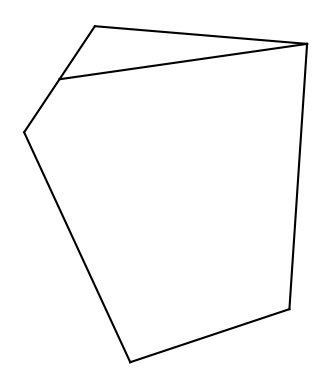

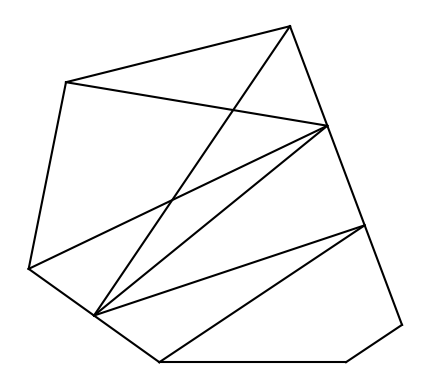

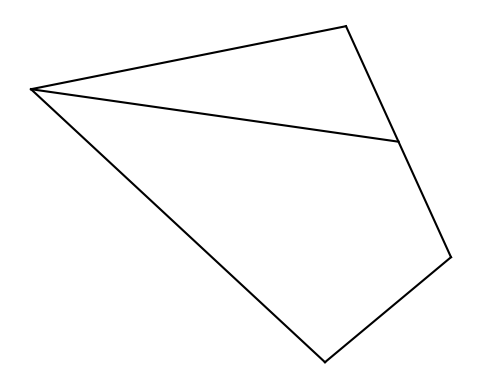

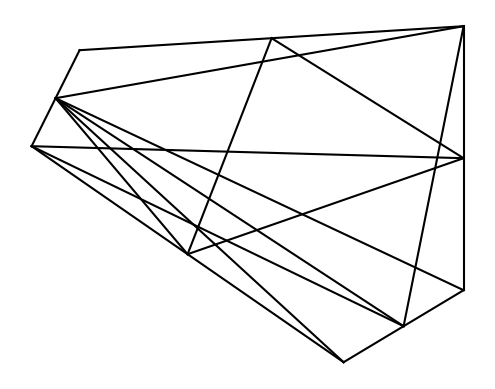

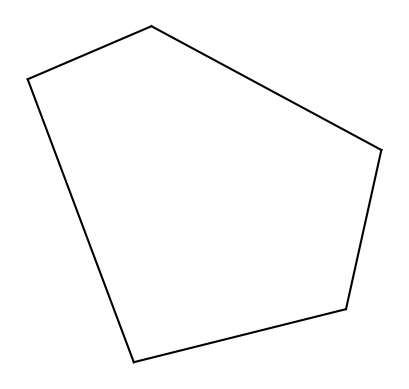

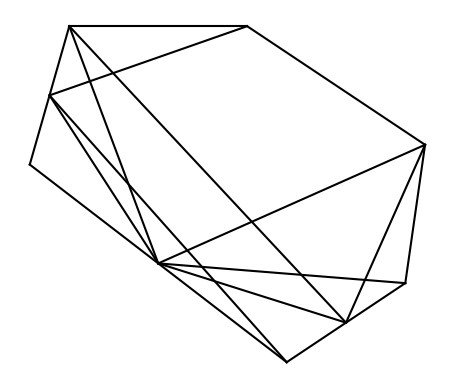

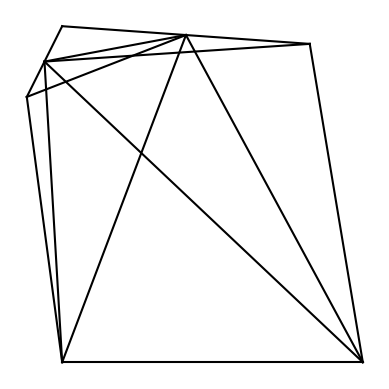

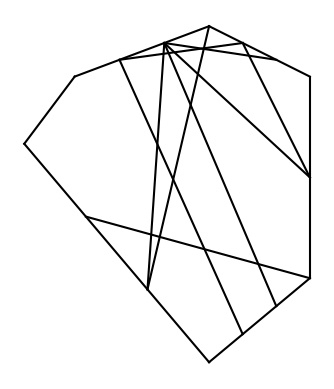

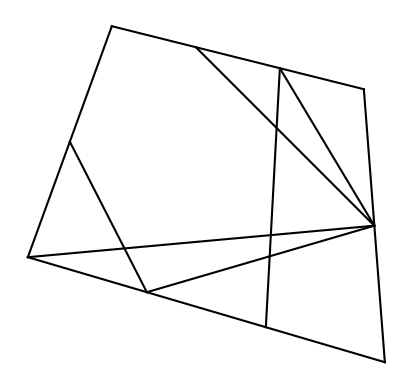

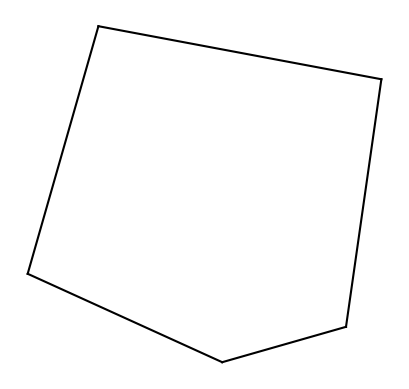

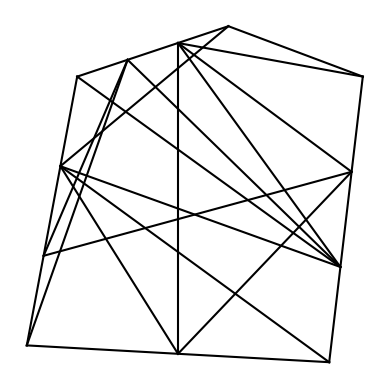

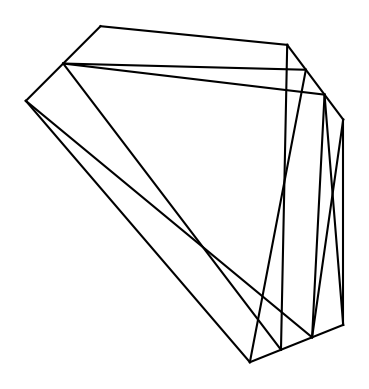

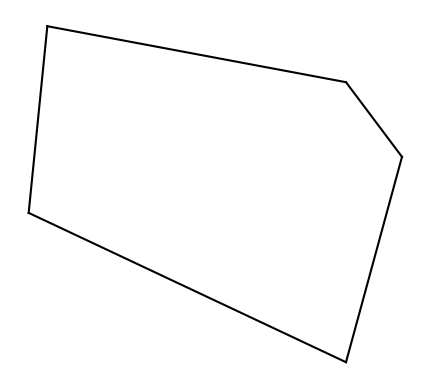

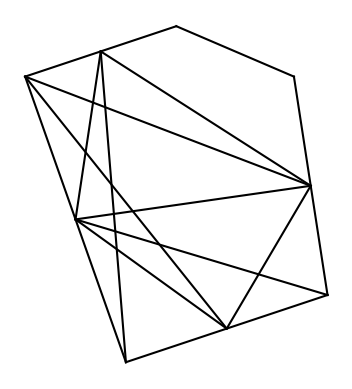

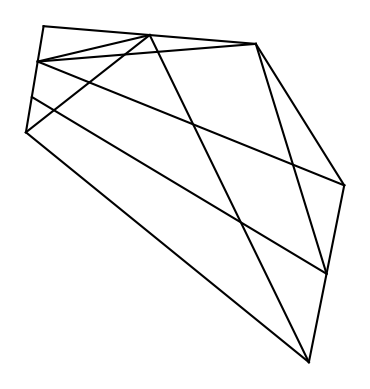

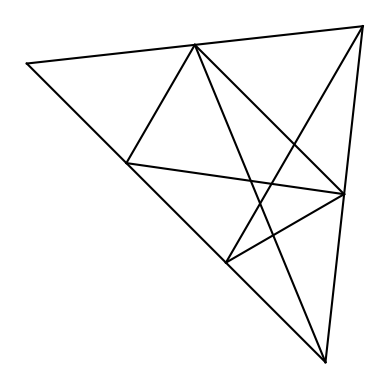

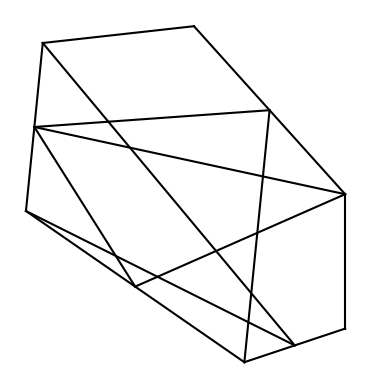

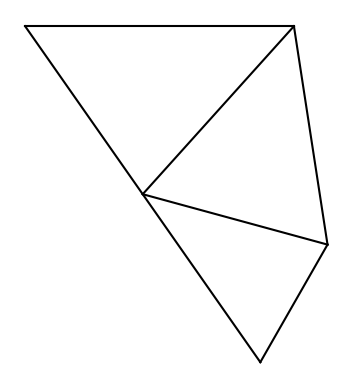

In [ ]:
num_generated = 0
for _ in range(10000):
  if num_generated>99:
    break
  status = generate_data()
  if status:
    num_generated+=1